<a id=top-page></a>

# Integrate `pykitPIV` with `LIMA`

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with pykitPIV</a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#train-LIMA-input-data">Prepare input dataset for LIMA</a></li>
        <li><a href="#train-LIMA-train">Begin training</a></li>
        </ul>
</ol>
<p></p>
</div>
<br>

***

In [18]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

In [2]:
image_size = (140,200)

In [3]:
size_buffer = 0

In [4]:
figsize = (5,3)

In [5]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=(4,4.1),
                         distances=(1,2),
                         densities=(0.05,0.1),
                         signal_to_noise=(5,20),
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          flow_mode='random',
                          gaussian_filters=(10,11),
                          n_gaussian_filter_iter=20,
                          sin_period=(30,300),
                          displacement=(0,10),
                          random_seed=random_seed)

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    time_separation=0.1)

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.6,0.65),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/10)

    return image

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 10 image pairs:

In [6]:
n_images = 10

We fix a random seed for generating the training set of PIV images:

In [7]:
training_random_seed = 100

In [8]:
image_train = generate_images(n_images, training_random_seed)

Particles added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


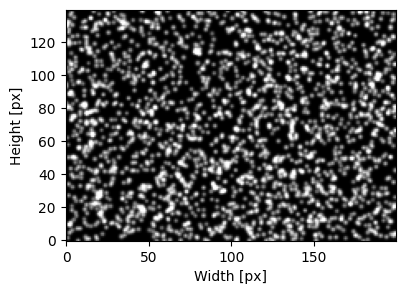

In [9]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [10]:
n_images = 10

We fix a random seed for generating the test set of PIV images (which is different from the random seed for the training set):

In [11]:
test_random_seed = 200

In [12]:
image_test = generate_images(n_images, test_random_seed)

Particles added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


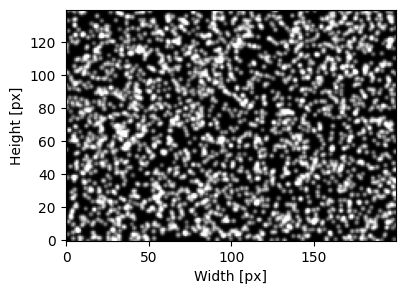

In [13]:
image_test.plot(0,
                instance=1,
                with_buffer=True,
                xlabel='Width [px]',
                ylabel='Height [px]',
                cmap='Greys_r',
                figsize=figsize);

In [14]:
image_test.remove_buffers()

Images do not have a buffer to remove!


In [15]:
image_test.images_I1[0].shape

(140, 200)

In [16]:
image_test.images_I1_no_buffer[0].shape

(140, 200)

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset for LIMA

[Go to the top](#top-page)

In [26]:
import glob
import os

import h5py
import numpy as np
import skimage.io as io
import torch
from torch.utils.data import Dataset


In [40]:
f = h5py.File(path, "r")

In [49]:
images = f["I"]

In [61]:
targets = f["target"]
targets = np.array(targets)

In [67]:
targets.shape

(3, 7, 180, 180)

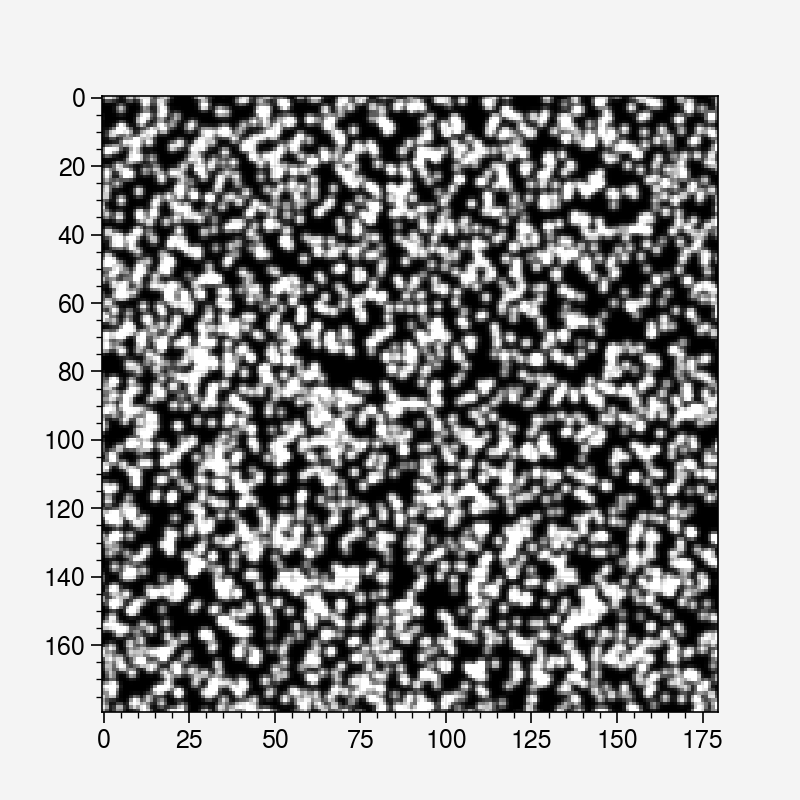

In [57]:
plt.imshow(np.array(images)[0,0,:,:], cmap='Greys_r')

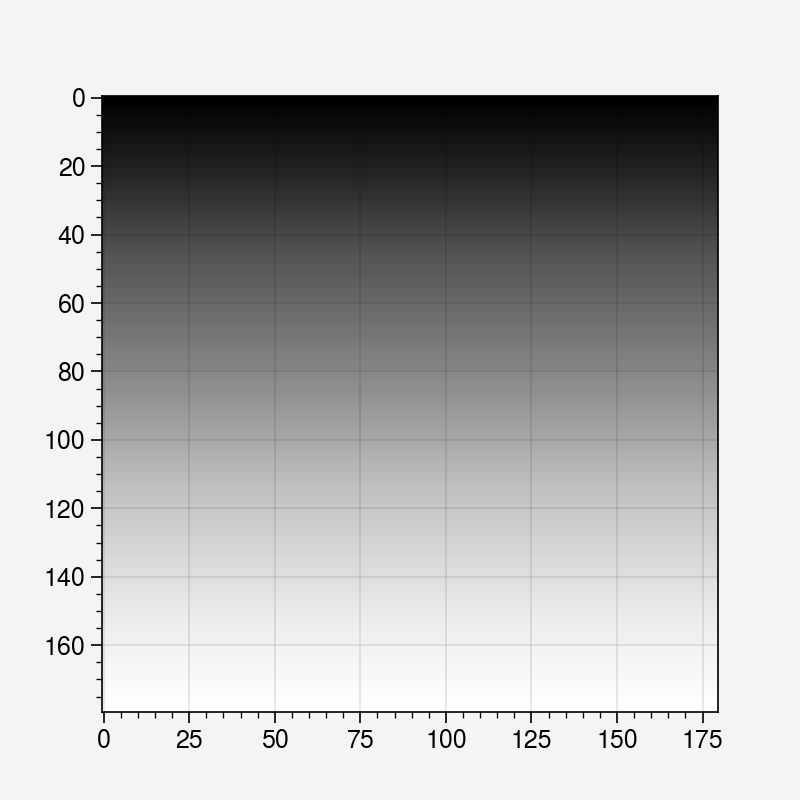

In [74]:
plt.imshow(targets[0,0,:,:], cmap='Greys_r')

In [75]:
f.close()


In [44]:
class HDF5Dataset(Dataset):
    """HDF5Dataset loaded"""

    def __init__(self, path, transform=None, n_samples=None, pin_to_ram=False):
        f = h5py.File(path, "r")
        self.data = f["I"]
        self.target = f["target"]
        if n_samples:
            self.data = self.data[:n_samples]
            self.target = self.target[:n_samples]
        if pin_to_ram:
            self.data = np.array(self.data)
            self.target = np.array(self.target)
            f.close()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data[idx], self.target[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [45]:
transform = torchvision.transforms.Compose([lima.transforms.RandomAffine(degrees=17, translate=(0.2, 0.2), scale=(0.9, 2.0)),
                                            lima.transforms.RandomHorizontalFlip(),
                                            lima.transforms.RandomVerticalFlip(),
                                            lima.transforms.ToTensor(),
                                            lima.transforms.RandomBrightness(factor=(0.5, 2)),
                                            lima.transforms.RandomNoise(std=(0, 0)),])

In [46]:
path = 'PIV_n3_s180_maxd10_rnd_v1.h5'

In [47]:
train_dataset = HDF5Dataset(path=path,
                            transform=transform,)

In [58]:
test_dataset = HDF5Dataset(path=path,
                           transform=transform,)

In [77]:
train_loader = DataLoader(train_dataset,
                          batch_size=1,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1)

<a id=train-LIMA-train></a>
### Begin training

[Go to the top](#top-page)

In [78]:
random_seed = 100

In [79]:
pl.seed_everything(random_seed, workers=True)

Global seed set to 100


100

In [ ]:
# 2. Setup train/test dataset
train_loader, test_loader = get_train_test_loader(args)
args.len_train_loader = len(train_loader)

Define the LIMA model:

In [ ]:
model = lima.LIMA(**dict_args)

In [ ]:
logger = pl.loggers.WandbLogger(project=args.project,
                                entity="empa305",
                                name=args.run,
                                save_dir=os.path.join(os.path.dirname(__file__), "logs"),
                                log_model=True)

logger.watch(model, 
             log="all")

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss",
                                                   save_top_k=1)

In [ ]:
trainer = pl.Trainer.from_argparse_args(args,
                                        accelerator=None if args.num_nodes == 1 else "ddp",
                                        gpus=1,
                                        logger=logger,
                                        max_epochs=args.epochs,
                                        callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],)

In [ ]:
trainer.fit(model, train_loader, test_loader)

***